# Micrograd: Tutorial on automatic differentiation using backpropagation
## by Andrej Karpathy

This notebook just contains the code that he copy-pastes and that is too long to type along, along with a time stamp referring to [the video](https://www.youtube.com/watch?v=VMj-3S1tku0).
You will need to change this code later, so it is easiest to follow along by just adding to this notebook.

# Preliminary exploration

## Required modules

Dependencies for math operations and plotting

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Functions of a single variable

In [2]:
def f(x):
    return 3.0*x**2 - 4.0*x + 5.0

In [3]:
f(3.0)

20.0

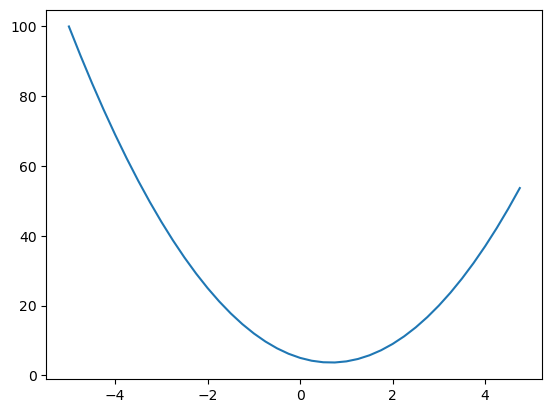

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

### Numerical derivative

In [5]:
h = 0.001
x = 3.0
(f(x + h) - f(x))/h  # fill in

14.00300000000243

## Functions of multiple variables

In [6]:
# Let's get more complex

# Inputs
a = 2.0
b = -3.0
c = 10.0

# Function
d = lambda a,b,c: a*b + c
print(d(a, b, c))

4.0


### Numerical derivative

Similar implementation to the video, but using a function to define `d` to make it a bit cleaner.

In [7]:
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0


# Function with variations

# Variation in a
d1 = d(a, b, c)
d2 = d(a+h, b, c)
print('Variation in a:')
print('   d1', d1)
print('   d2', d2)
print('   slope', (d2 - d1)/h)  # the derivative

# Variation in b
d1 = d(a, b, c)
d2 = d(a, b+h, c)
print('\nVariation in b:')
print('   d1', d1)
print('   d2', d2)
print('   slope', (d2 - d1)/h)  # the derivative

# Variation in c
d1 = d(a, b, c)
d2 = d(a, b, c+h)
print('\nVariation in c:')
print('   d1', d1)
print('   d2', d2)
print('   slope', (d2 - d1)/h)  # the derivative

Variation in a:
   d1 4.0
   d2 3.999699999999999
   slope -3.000000000010772

Variation in b:
   d1 4.0
   d2 4.0002
   slope 2.0000000000042206

Variation in c:
   d1 4.0
   d2 4.0001
   slope 0.9999999999976694


# Micrograd

## Value class

In [8]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        # Print a nice output
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # Addition operator
        other = other if isinstance(other, Value) else Value(other)  # if needed convert numeric to Value
        out = Value(self.data + other.data, (self, other), '+')
        
        # Define the local derivate backwards propagation
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad    
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):  # other + self, multiplication the other way around
        return self + other
    
    def __sub__(self, other):  # self - other, subtraction
        return self + (-other)
    
    def __rsub__(self, other):  # other - self, subtraction
        return (-self) + other
    
    def __mul__(self, other):
        # Multiplication operator
        other = other if isinstance(other, Value) else Value(other)  # if needed convert numeric to Value
        out = Value(self.data * other.data, (self, other), '*')
        
        # Define the local derivate backwards propagation
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad    
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):  # other * self, multiplication the other way around
        return self * other
    
    def __neg__(self):  # -self, negative values
        return self * (-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        
        out._backward = _backward
        
        return out
        
    def __truediv__(self, other):  # self / other, division
        return self * other**(-1)
    
    def tanh(self):
        # Hyperbolic tangent function
        x = self.data
        t = (math.exp(2.0*x) - 1.0)/(math.exp(2.0*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        # Define the local derivate backwards propagation
        def _backward():
            self.grad += (1 - t**2) * out.grad 
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad = out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def backward(self):
        # Topological sorting
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # Go over the sorted noded and compute backwards propagation in reverse order
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

In [9]:
# Define three values
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print('The values a, b,c:')
print(a)
print(b)
print(c)

# Do some operations with them and print the result
e = a*b; e.label = 'e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f

print('\nThe value of d:')
print(d)
print('\nThe value of L:')
print(L)

The values a, b,c:
Value(data=2.0)
Value(data=-3.0)
Value(data=10.0)

The value of d:
Value(data=4.0)

The value of L:
Value(data=-8.0)


## Visualization code (at time 25:07)

Copy pasted code so with visualization functions

In [10]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
            
    return dot

You can now visualize the ``Value`` objects

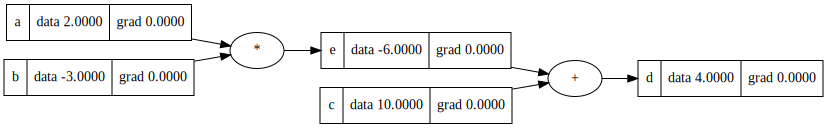

In [11]:
draw_dot(d)

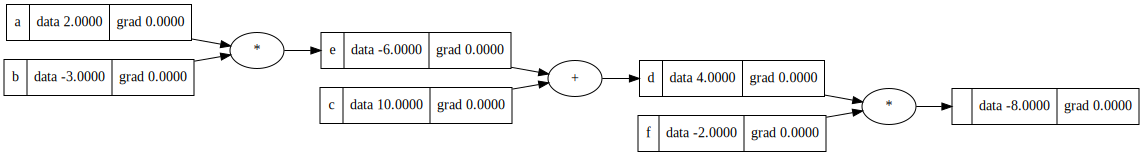

In [12]:
draw_dot(L)

Back propagation by hand

One important point to have in mind here is:

$$
L(f, d) = f\cdot d
$$

with $d = d(c, e)$ or with $e = e(a, b)$ therefore $d = d(c, e(a, b))$. If we expand the derivative we have:

$$
\frac{\partial L}{\partial f} = \frac{\partial (f\cdot d)}{\partial f} = \frac{\partial f}{\partial f} d + \frac{\partial d}{\partial f} f = d + 0 = d.
$$

and 

$$
\frac{\partial L}{\partial d} = \frac{\partial (f\cdot d)}{\partial d} = \frac{\partial f}{\partial d} d + \frac{\partial d}{\partial d} f = 0 + f = f.
$$

Note that, if $d = f + c$ instead of $d = e + c$ then we would have:
$$
\frac{\partial L}{\partial f} = \frac{\partial (f\cdot d)}{\partial f} = \frac{\partial f}{\partial f} d + \frac{\partial d}{\partial f} f = \frac{\partial f}{\partial f} d + \frac{\partial (f + c)}{\partial f} f = d + f.
$$

Another important point to have in mind, regarding notation, is the following. although it is written `d.grad`, in fact this means the derivative of `L` with respect to `d` and not the gradient of `d`. In more general terms, `d.grad` is the derivative of the root expression (highest level) with respect to the variable we are considering.

In [13]:
# L = d * f
# d = e + c
# e = b * a

# So for the different layers (levels) of the expression we have:
# L = d * f            (first level)
# L = (e + c) * f      (second level)
# L = ((b*a) + c) * f  (third level)
L.grad = 1.0 # initialize it to it value, since dL/dL = 1
d.grad = f.data  #  L = d*f => dL/dd = f
f.grad = d.data  #  L = d*f => dL/df = d

So now to compute $\frac{\partial L}{\partial c}$ we need to use the chain rule to get:

$$
\frac{\partial L}{\partial c} = \frac{\partial L(d, f)}{\partial c} = \frac{\partial L(d, f)}{\partial d}\frac{\partial d}{\partial c} + \frac{\partial L(d, f)}{\partial f}\frac{\partial f}{\partial c} = \frac{\partial L(d, f)}{\partial d}\frac{\partial (e + c)}{\partial c} + 0 = \frac{\partial L(d, f)}{\partial d}\cdot 1 = \frac{\partial L(d, f)}{\partial d}.
$$

We can see that we reused $\frac{\partial L(d, f)}{\partial d}$ and $\frac{\partial L(d, f)}{\partial f}$ that was computed in the previous step.

This expression clearly shows that at each point of the graph we just need to have the derivative of the upstream expression with respect to the parent and the derivative of the parent with respect to the child. Combining the two we can easily get the derivative of the root expression with respect to the node.

In [14]:
c.grad = d.grad  # this is just the expression from the chain rule
e.grad = d.grad  # this is just the expression from the chain rule

In [15]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label ='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0 + h, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d'
    d.data = d.data
    f = Value(-2.0, label='f')
    L = d*f; L.label ='L'
    
    L2 = L.data
    
    print('Derivative:', (L2 - L1)/h)
    
lol()
    
    

Derivative: -1.9999999999953388


## Basic Neuron

Plot the ``tanh`` activation function

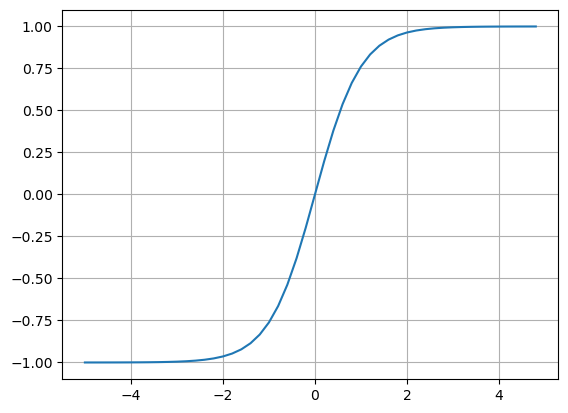

In [16]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

Basic neuron with two inputs, two weights, one bias, and one output, as Value object

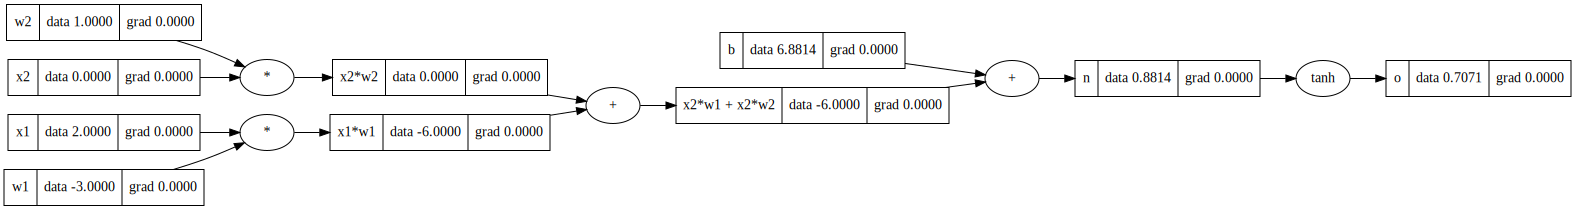

In [17]:
# Input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# Computation of x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1' 
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x2*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
draw_dot(n)

o = n.tanh(); o.label='o'  # you first need to uncomment tanh in the definition of Value
draw_dot(o)

## Topological sort code

In [18]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

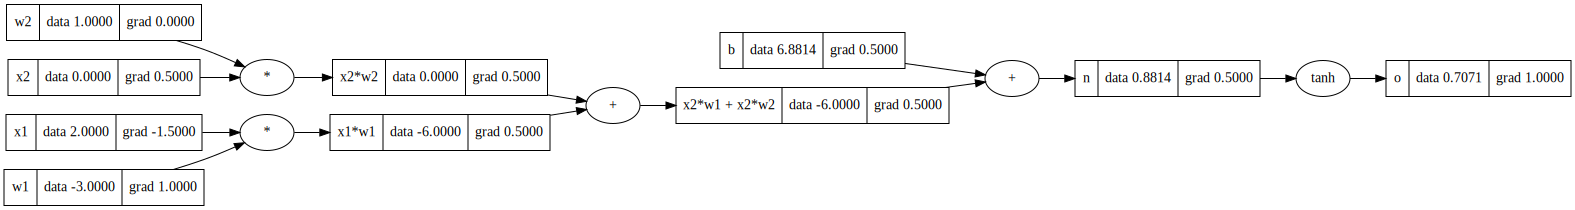

In [19]:
o.grad = 1.0 # initialize the gradient of the last node

# Initialize the gradients in the order given by the topological ordering
for node in reversed(topo):
    node._backward()
    
draw_dot(o)

Once this function is included in Value object, we can then compute the gradient in one go (**do not forget to re-initialize the object `o`**)

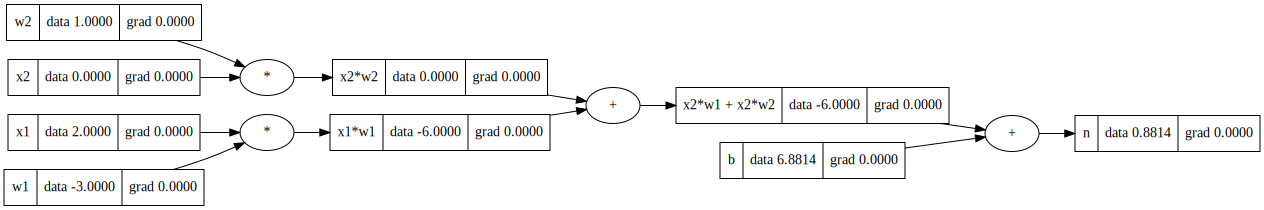

In [28]:
# Input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# Computation of x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1' 
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x2*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
draw_dot(n)

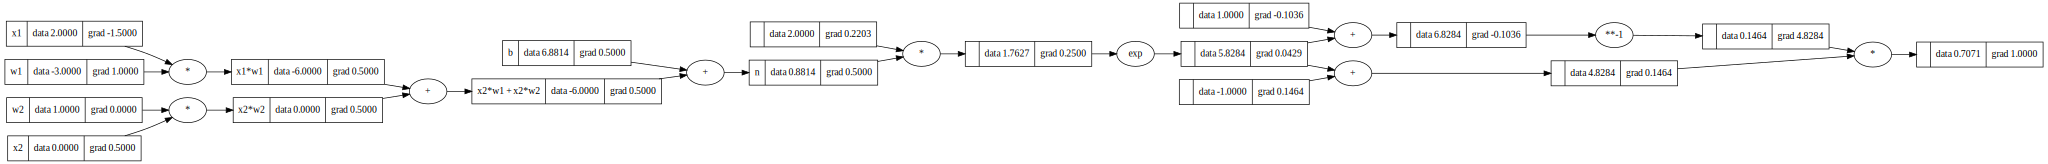

In [29]:
#o = n.tanh(); o.label='o'

# ---
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ---

o.backward()
draw_dot(o)

In [21]:
import os
cwd = os.getcwd()
print(cwd)

/Users/apalha/work/workshops/eScienceCenter/back_propagation/machine_learning_sig/micrograd/finished_sessions


## Extending Value to enable operations with numeric values

In [22]:
print("a    : ", a)
print("c    : ", c)
print("a + 1: ", a + 1)
print("1 + a: ", 1 + a)
print("a - c: ", a - c)
print("a - 1: ", a - 1)
print("1 - a: ", 1 - a)
print("a * 2: ", a * 2)
print("2 * a: ", 2 * a)
print("e^a  : ", a.exp())
print("a/c  : ", a/c)
print("a**3 : ", a**3)

a    :  Value(data=2.0)
c    :  Value(data=10.0)
a + 1:  Value(data=3.0)
1 + a:  Value(data=3.0)
a - c:  Value(data=-8.0)
a - 1:  Value(data=1.0)
1 - a:  Value(data=-1.0)
a * 2:  Value(data=4.0)
2 * a:  Value(data=4.0)
e^a  :  Value(data=7.38905609893065)
a/c  :  Value(data=0.2)
a**3 :  Value(data=8.0)


## 1:39:54 Pytorch comparison

In [23]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## 1:44:37 Neuron

In [24]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

## 1:48:22 Layer

In [25]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

## 1:49:19 MLP

In [26]:
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## 1:51:07 Example dataset

In [27]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets